# **Stroke Classifier - Demo**

Teste dos classificadores lineares e por árvore de decisão para predição de AVC e determinação de possíveis de risco.

Base de dados: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [1]:
import pandas as pd
import numpy as np
from classifiers.LinearClassifier import LinearClassifier
from classifiers.TreeClassifier import TreeClassifier

# ***Primeiro Teste***: sem poda do DataFrame

O primeiro teste é realizado considerando todos os valores da base dados obtida. Ou seja, não é considerado que são poucos os casos de AVC na base de dados, o que pode gerar um viés de classificação.

In [2]:
# Carrega o DataFrame
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

## **Classificador Linear**

O treinamento do classificador linear é feito com 50% da base de dados, utilizando então o conceito de descida pelo gradiente.

Primeiro, inicializamos os pesos com valores iniciais aleatórios, e então realizamos o treinamento com 5000 iterações. A cada uma, utilizamos os valores de entrada com os pesos atuais para tentar prever a saída, multiplicando cada variável pelo seu respectivo peso e somando o termo independente (bias). 

$$
\hat{y} =
b + \sum_{n}
\begin{bmatrix}
    w_1 & w_2 & ... & w_{N-1}
\end{bmatrix}
\begin{bmatrix}
    x_1 \\
    x_2 \\
    ... \\
    x_{N-1}
\end{bmatrix}
$$
$$
\hat{y} = b + \bold{w^T} \bold{x}
$$

Como temos os resultados reais, podemos calcular o erro quadrático médio (MSE) da nossa estimativa.

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2
$$

Então, utilizando o MSE e o gradiente da função de perda em função do peso, podemos saber a "direção" que devemos seguir. Considerando que o gradiente é o vetor que "aponta" para a direção de maior crescimento da função, e, como buscamos minimzar o erro, seguimos, portanto, na sua direção inversa. Assim, atualizamos os pesos somando a eles uma pequena fração do resultado do gradiente multiplicado por $-1$ (fazemos isso multiplicando por uma taxa de aprendizado $\alpha$).

$$
w_i = w_i - \alpha \frac{\partial MSE}{\partial w_i}
$$

Ao final do processo, temos os pesos que melhor se ajustam aos dados de treinamento. Então, podemos utilizar esses pesos para prever os resultados da base de teste, e calcular a acurácia do modelo.

---

*OBS: o processo de realização de todos os passos acima está **comentado no código da própria classe do classificador `LinearClassifier.py`**.*

In [3]:
# Testa o LinearClassifier com o DataFrame

clf = LinearClassifier(df) # Carrega (dados filtrados DENTRO da classe)
clf.fit() # Treina
clf.score() # Prediz
print(f'LinearClassifier accuracy: {clf.accuracy() * 100 :.2f}%\n') # Printa a acurácia

# Printa as 5 features mais importantes segundo o LinearClassifier
# Ou seja, as features com maiores pesos
print(f'LinearClassifier most important features:')
for i in range(1, 6):
    print(f'{i}. {clf.X.columns[np.argsort(clf.w.T)[0][-i]]}')


LinearClassifier accuracy: 95.85%

LinearClassifier most important features:
1. work_type_Never_worked
2. work_type_children
3. work_type_Private
4. work_type_Govt_job
5. work_type_Self-employed


É possível começar a perceber instabilidades no classificador linear: ele apresentou as 5 categorias de uma mesma feature do dataframe original como as com maior peso, o que não faz sentido.

### **Analisando o `y_est`**

Para ter melhor entendimento das previsões do classificador, podemos analisar o vetor `y_est`, que contém as previsões para cada entrada da base de teste, analisando, por exemplo, a quantidade de casos previstos como ou não AVC em relação ao total de previsões.

In [6]:
print(clf.y_est)
print(f'Número total de predições: {clf.y_est.shape[1]}')
print(f'Número de predições para AVC (positivo): {np.sum(clf.y_est > 0)}')
print(f'Número de predições para não AVC (negativo): {np.sum(clf.y_est < 0)}')


[[-0.83564066 -0.83943591 -0.99382721 ... -1.02276807 -0.99901827
  -0.93261223]]
Número total de predições: 2455
Número de predições para AVC (positivo): 0
Número de predições para não AVC (negativo): 2455


Percebe-se algo muito interessante: o classificador chutou 100% das vezes em não ter ocorrido um AVC. Tal evento levanta a suspeita de presença de viés de classificação, o que será confirmado pela comparação do nosso preditor com um preditor que chuta sempre o caso mais frequente no DataFrame.

### **Hipótese Nula**

A acurácia é uma boa medida de desempenho de um classificador, mas é importante sempre colocá-la a teste, já que pode apresentar viéses. Por exemplo, se uma das saídas da base de dados é muito mais frequente que a outra, o classificador pode acabar sempre devolvendo essa saída como predição. Nesse caso, a acurácia não significaria de maneira nenhuma um bom desempenho.

Portanto, a hipótese nula é a de que o classificador não é melhor do que um que apenas chuta a resposta mais frequente no DataFrame. Para testar essa hipótese, calculamos a acurácia do classificador que chuta sempre a resposta mais frequente no DataFrame, e comparamos com a acurácia do nosso classificador.

In [9]:
# Descobre se temos mais 1s ou -1s no y_test

print(f'Number of 1s in y_test: {np.sum(clf.y_test == 1)}')
print(f'Number of -1s in y_test: {np.sum(clf.y_test == -1)}')

# Cria um Numpy array do tamanho do y_test com apenas -1s

y_test = np.ones(clf.y_test.shape) * -1

# Compara a acurácia do classificador com um que chuta -1 para tudo

print(f'\nLinearClassifier accuracy vs. -1s classifier accuracy: {clf.accuracy() * 100 :.2f}% vs. {np.mean(np.sign(clf.y_test)==np.sign(y_test)) * 100 :.2f}%')

Number of 1s in y_test: 102
Number of -1s in y_test: 2353

LinearClassifier accuracy vs. -1s classifier accuracy: 95.85% vs. 95.85%


Como suspeitado, o número de casos em que ocorreram AVC é muito inferior aos que não ocorreram. Junto a isso, como descrito anteriormente, o classificador chutou apenas que não houve AVC para a base de teste, isto é, exatamente a mesma acurácia do classificador que chuta sempre a resposta mais frequente. Portanto, não é possível rejeitar a hipótese nula.

Antes de testarmos podas na base de dados para evitar o viés, vamos testar o mesmo processo com o classificador por árvore de decisão e observar se o mesmo fenômeno acontece.

---

## **Classificador de Árvore de Decisão**

O classificador de árvore de decisão é treinado com 50% da base de dados, utilizando o conceito de entropia.

Primeiro, calculamos a entropia da base de dados, que é dada por:

$$
H(S) = - \sum_{i} p(x_i) \log_2 (p(x_i))
$$

A entropia é medida em bits (por isso sua base $2$) e busca descrever a quantidade de informação que uma variável aleatória carrega. Podemos pensar nesse conceito em perguntas em um jogo de adivinhação. Uma pergunta com alta entropia seria aquela que "deu mais informação", isto é, que reduziu mais o número de possibilidades, diminuindo a entropia, a desordem, do sistema. Dessa maneira, o classificador por árvore de decisão busca montar uma árvore que, no menor número de "perguntas" possível, reduza ao máximo o número de possibilidades, classificando o caso como AVC ou não AVC.

Para isso, foi utilizada a classe `DecisionTreeClassifier.py` do **sklearn**, que ajusta seus parâmetros automaticamente.

---

*OBS: o processo de realização de todos os passos acima está **comentado no código da própria classe do classificador `TreeClassifier.py`**.*

In [10]:
# Testa o TreeClassifier com o DataFrame

clf = TreeClassifier(df)
clf.fit()
clf.score()
print(f'TreeClassifier accuracy: {clf.accuracy() * 100 :.2f}%\n')

# Printa as 5 features mais importantes segundo o TreeClassifier

print(f'TreeClassifier most important features:')
for i in range(1, 6):
    print(f'{i}. {clf.X.columns[np.argsort(clf.tree.feature_importances_)[-i]]}')

TreeClassifier accuracy: 93.24%

TreeClassifier most important features:
1. age_elder
2. Residence_type_Urban
3. heart_disease
4. hypertension
5. work_type_Private


A acurácia encontrada por esse classificador também é alta, no entanto, precisamos nos atentar ao possível viés de classificação.

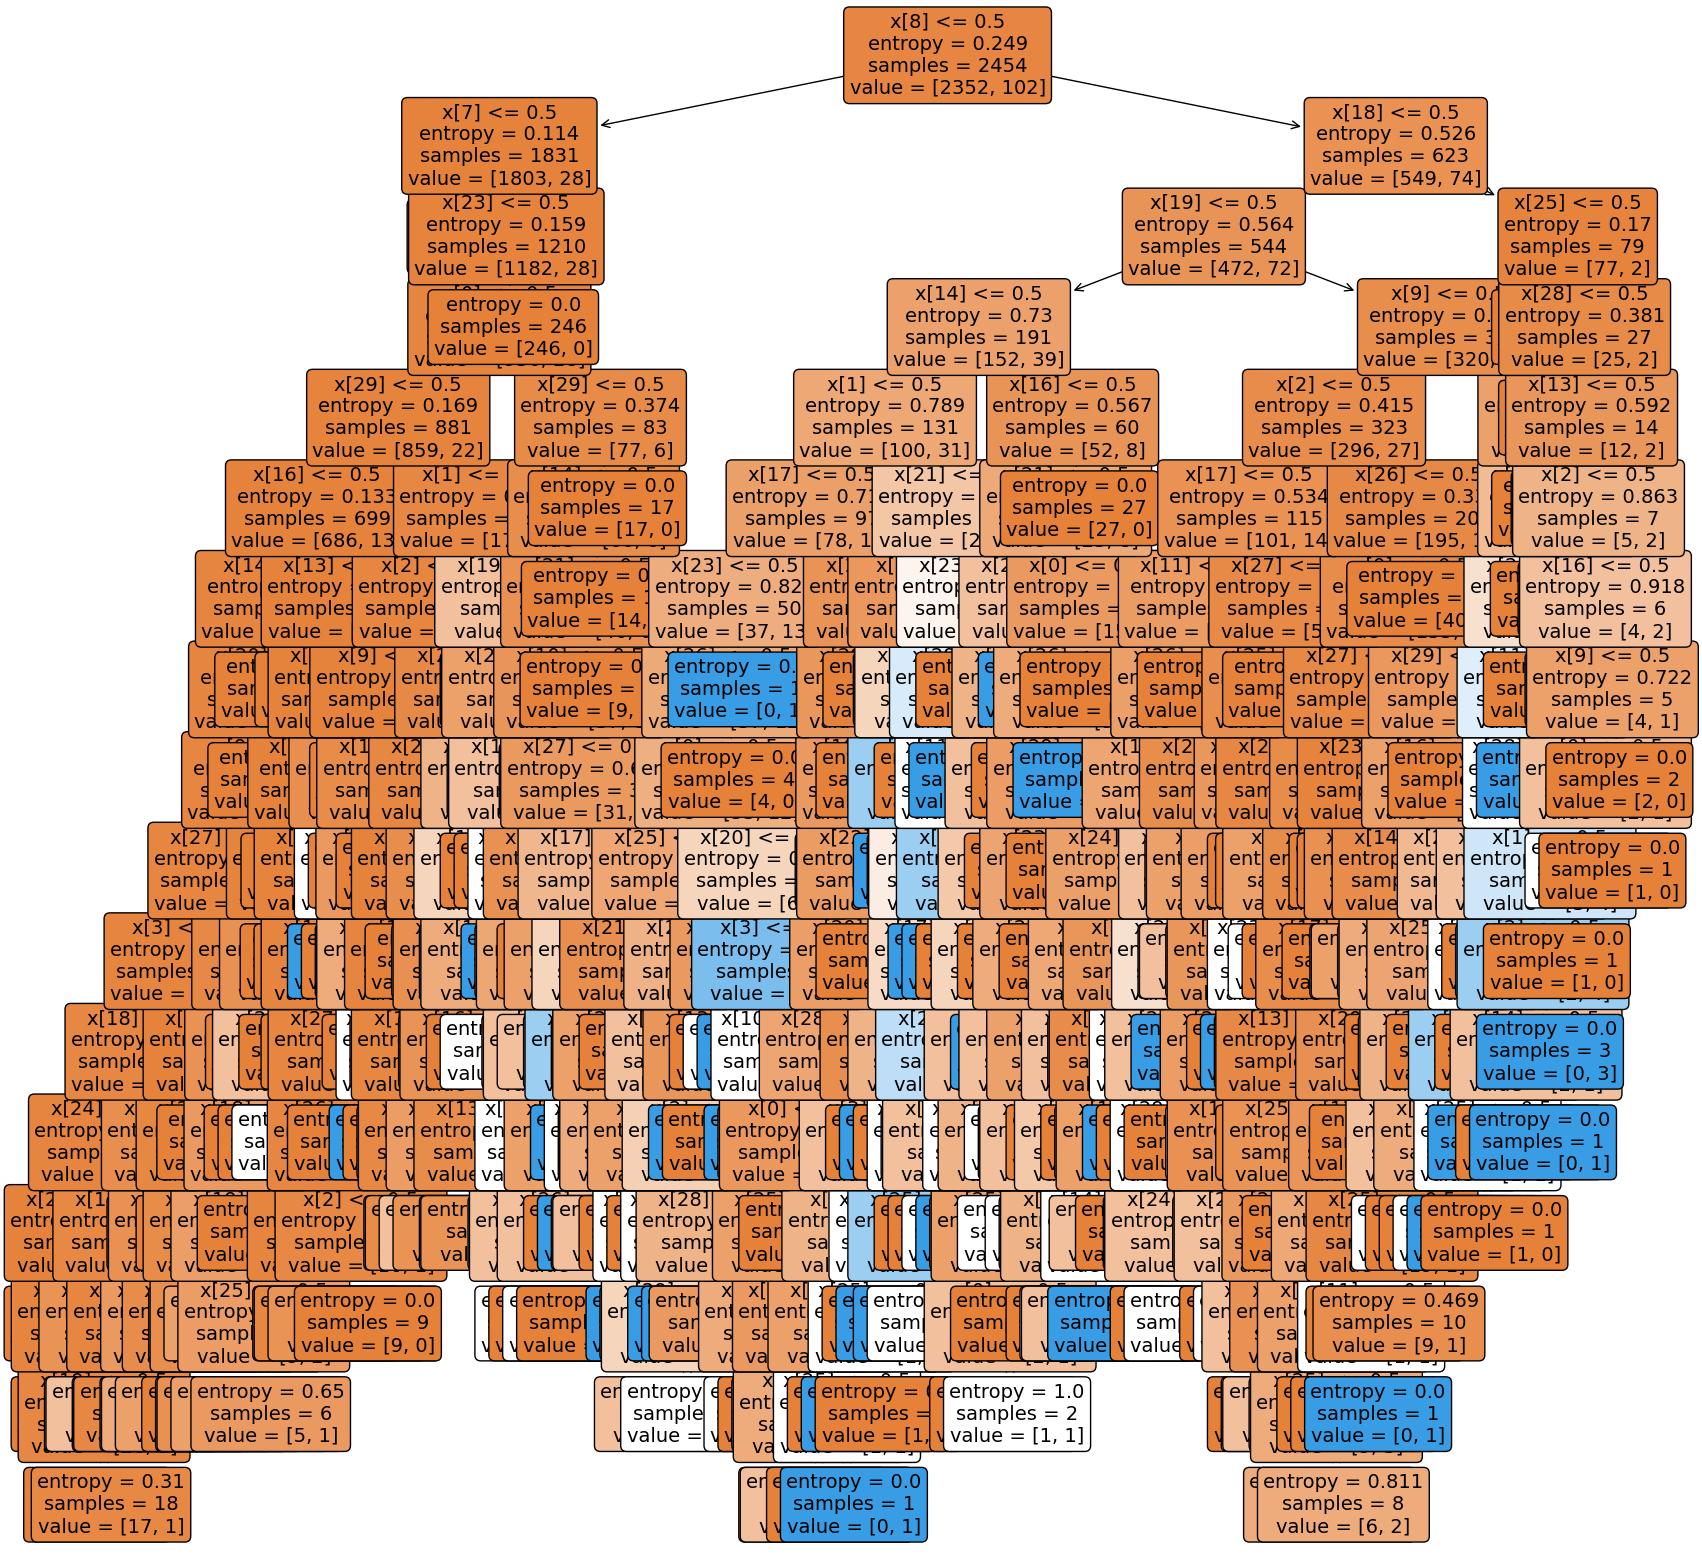

In [14]:
# Plota a árvore de decisão do TreeClassifier

clf.plot()

### **Analisando o `y_est`**

Da mesma maneira, analisamos as predições desse classificador em relação ao total de previsões.

In [12]:
print(clf.y_est)
print(f'Número total de predições: {clf.y_est.shape[0]}')
print(f'Número de predições para AVC (positivo): {np.sum(clf.y_est > 0)}')
print(f'Número de predições para não AVC (negativo): {np.sum(clf.y_est < 0)}')


[-1. -1. -1. ... -1. -1. -1.]
Número total de predições: 2455
Número de predições para AVC (positivo): 78
Número de predições para não AVC (negativo): 2377


Assim como com o classificador linear, percebe-se que praticamente todos os casos foram classificados como não AVC. Portanto, podemos suspeitar de um viés de classificação.

### **Hipótese Nula**

Utilizaremos a mesma hipótese nula de que o classificador não é melhor do que um que apenas chuta a resposta mais frequente no DataFrame. Para testar essa hipótese, calculamos a acurácia do classificador que chuta sempre a resposta mais frequente no DataFrame, e comparamos com a acurácia do nosso classificador.

In [14]:
# Descobre se temos mais 1s ou -1s no y_test

print(f'Number of 1s in y_test: {np.sum(clf.y_test == 1)}')
print(f'Number of -1s in y_test: {np.sum(clf.y_test == -1)}')

# Cria um Numpy array do tamanho do y_test com apenas -1s

y_test = np.ones(clf.y_test.shape) * -1

# Compara a acurácia do classificador com um que chuta -1 para tudo

print(f'\nTreeClassifier accuracy vs. -1s classifier accuracy: {clf.accuracy() * 100 :.2f}% vs. {np.mean(np.sign(clf.y_test)==np.sign(y_test)) * 100 :.2f}%')

Number of 1s in y_test: 106
Number of -1s in y_test: 2349

TreeClassifier accuracy vs. -1s classifier accuracy: 93.24% vs. 95.68%


Nesse caso, temos uma situação ainda pior: o nosso classificador performa pior do que o classificador que chuta sempre a resposta mais frequente. Portanto, não é possível rejeitar a hipótese nula.

# **Problema**

Nossos classificadores chutam todos como não tendo AVC. A hipótese é que isso está ocorrendo pois há muito mais casos que não tiveram AVC do que tiveram AVC no dataset, o que dá *bias* aos dados. Portanto, uma possível solução é podar, por exemplo, ao analisar um subset do dataset com o mesmo número de casos com AVC do que sem AVC. Dessa maneira, buscaremos um dataset mais balanceado, e, portanto, com menos viés.

---

# ***Segundo Teste***: com poda do DataFrame

Vamos ter apenas metade dos dados com AVC e metade dos dados sem AVC, o equilibrando. Assim, podemos testar novamente os classificadores e verificar se o viés de classificação ainda está presente.

In [16]:
# Carrega o DataFrame

df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

# Poda o DataFrame para ter o mesmo número de stroke = 1 e stroke = 0

df = df[df['stroke'] == 1].append(df[df['stroke'] == 0].sample(n=df[df['stroke'] == 1].shape[0]))

df.head()

C:\Users\neodr\AppData\Local\Temp\ipykernel_24220\3958300238.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df[df['stroke'] == 1].append(df[df['stroke'] == 0].sample(n=df[df['stroke'] == 1].shape[0]))


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

O tamanho do dataset diminuiu substancialmente, pois, dos mais de 5000 casos, apenas 249 tiveram AVC. Portanto, o dataset foi reduzido para 498 casos, sendo 249 com AVC e 249 sem AVC.

Claro, esperamos encontrar uma menor acurácia, já que teremos um treinamento muito mais limitado para os classificadores. No entanto, também nos interessa verificar um menor viés para tentarmos determinar fatores de risco para AVC.

In [17]:
print(f'Número de casos com AVC: {df[df["stroke"] == 1].shape[0]}')
print(f'Número de casos sem AVC: {df[df["stroke"] == 0].shape[0]}')

Número de casos com AVC: 249
Número de casos sem AVC: 249


## **Classificador Linear**

O processo do classificador linear é o mesmo, agora com uma base de dados podada.

In [19]:
# Testa o LinearClassifier com o DataFrame

clf = LinearClassifier(df)
clf.fit()
clf.score()
print(f'LinearClassifier accuracy: {clf.accuracy() * 100 :.2f}%\n')

# Printa as 5 features mais importantes segundo o LinearClassifier

print(f'LinearClassifier most important features:')
for i in range(1, 6):
    print(f'{i}. {clf.X.columns[np.argsort(clf.w.T)[0][-i]]}')

LinearClassifier accuracy: 72.00%

LinearClassifier most important features:
1. age_elder
2. smoking_status_smokes
3. hypertension
4. bmi_obese
5. smoking_status_Unknown


Verifica-se, como esperado, uma menor acurácia. No entanto, ainda encontramos uma precisão alta, de mais de 70% de acertos.

### **Analisando o `y_est`**

Da mesma maneira, analisamos as predições desse classificador em relação ao total de previsões.

In [20]:
print(f'Número total de predições: {clf.y_est.shape[1]}')
print(f'Número de predições para AVC (positivo): {np.sum(clf.y_est > 0)}')
print(f'Número de predições para não AVC (negativo): {np.sum(clf.y_est < 0)}')

Número total de predições: 225
Número de predições para AVC (positivo): 97
Número de predições para não AVC (negativo): 128


O número de previsões agora se encontra muito mais equilibrado. Veremos se isso se reflete na hipótese nula.

### **Analisando (novamente) a Hipótese Nula**

Agora com poda nos dados.

In [21]:
# Descobre se temos mais 1s ou -1s no y_test

print(f'Number of 1s in y_test: {np.sum(clf.y_test == 1)}')
print(f'Number of -1s in y_test: {np.sum(clf.y_test == -1)}')

# Cria um Numpy array do tamanho do y_test com apenas 1s

y_test = np.ones(clf.y_test.shape) * 1

# Compara a acurácia do classificador com um que chuta 1 para tudo

print(f'\nLinearClassifier accuracy vs. 1s classifier accuracy: {clf.accuracy() * 100 :.2f}% vs. {np.mean(np.sign(clf.y_test)==np.sign(y_test)) * 100 :.2f}%')

Number of 1s in y_test: 114
Number of -1s in y_test: 111

LinearClassifier accuracy vs. 1s classifier accuracy: 72.00% vs. 50.67%


Percebe-se agora que o classificador performa melhor do que o classificador que chuta sempre a resposta mais frequente. Portanto, é possível rejeitar a hipótese nula e considerar o classificador desenvolvido como adequado para o problema.

---

## **Classificador de Árvore de Decisão**

Agora, vamos realizar o mesmo processo para o classificador por árvore de decisão.

In [22]:
# Testa o TreeClassifier com o DataFrame

clf = TreeClassifier(df)
clf.fit()
clf.score()
print(f'TreeClassifier accuracy: {clf.accuracy() * 100 :.2f}%\n')

# Printa as 5 features mais importantes segundo o TreeClassifier

print(f'TreeClassifier most important features:')
for i in range(1, 6):
    print(f'{i}. {clf.X.columns[np.argsort(clf.tree.feature_importances_)[-i]]}')

TreeClassifier accuracy: 63.56%

TreeClassifier most important features:
1. age_elder
2. age_adult
3. hypertension
4. avg_glucose_level_very high
5. bmi_obese


Para esse classificador, encontramos uma acurácia menor que o classificador linear, mas ainda assim relativamente alta. No entanto, vale destacar que a árvore de decisão se mostra mais constante na escolha das features de maior importância, enquanto o linear varia mais caso executado diversas vezes, apresentando inclusive features "opostas", como bmi alto e baixo como fatores de risco ao mesmo tempo. Portanto, a árvore de decisão se mostra mais robusta, sempre mantendo, por exemplo, a idade avançada como fator de maior peso, entre outros que variam pouco, como o bmi obeso.

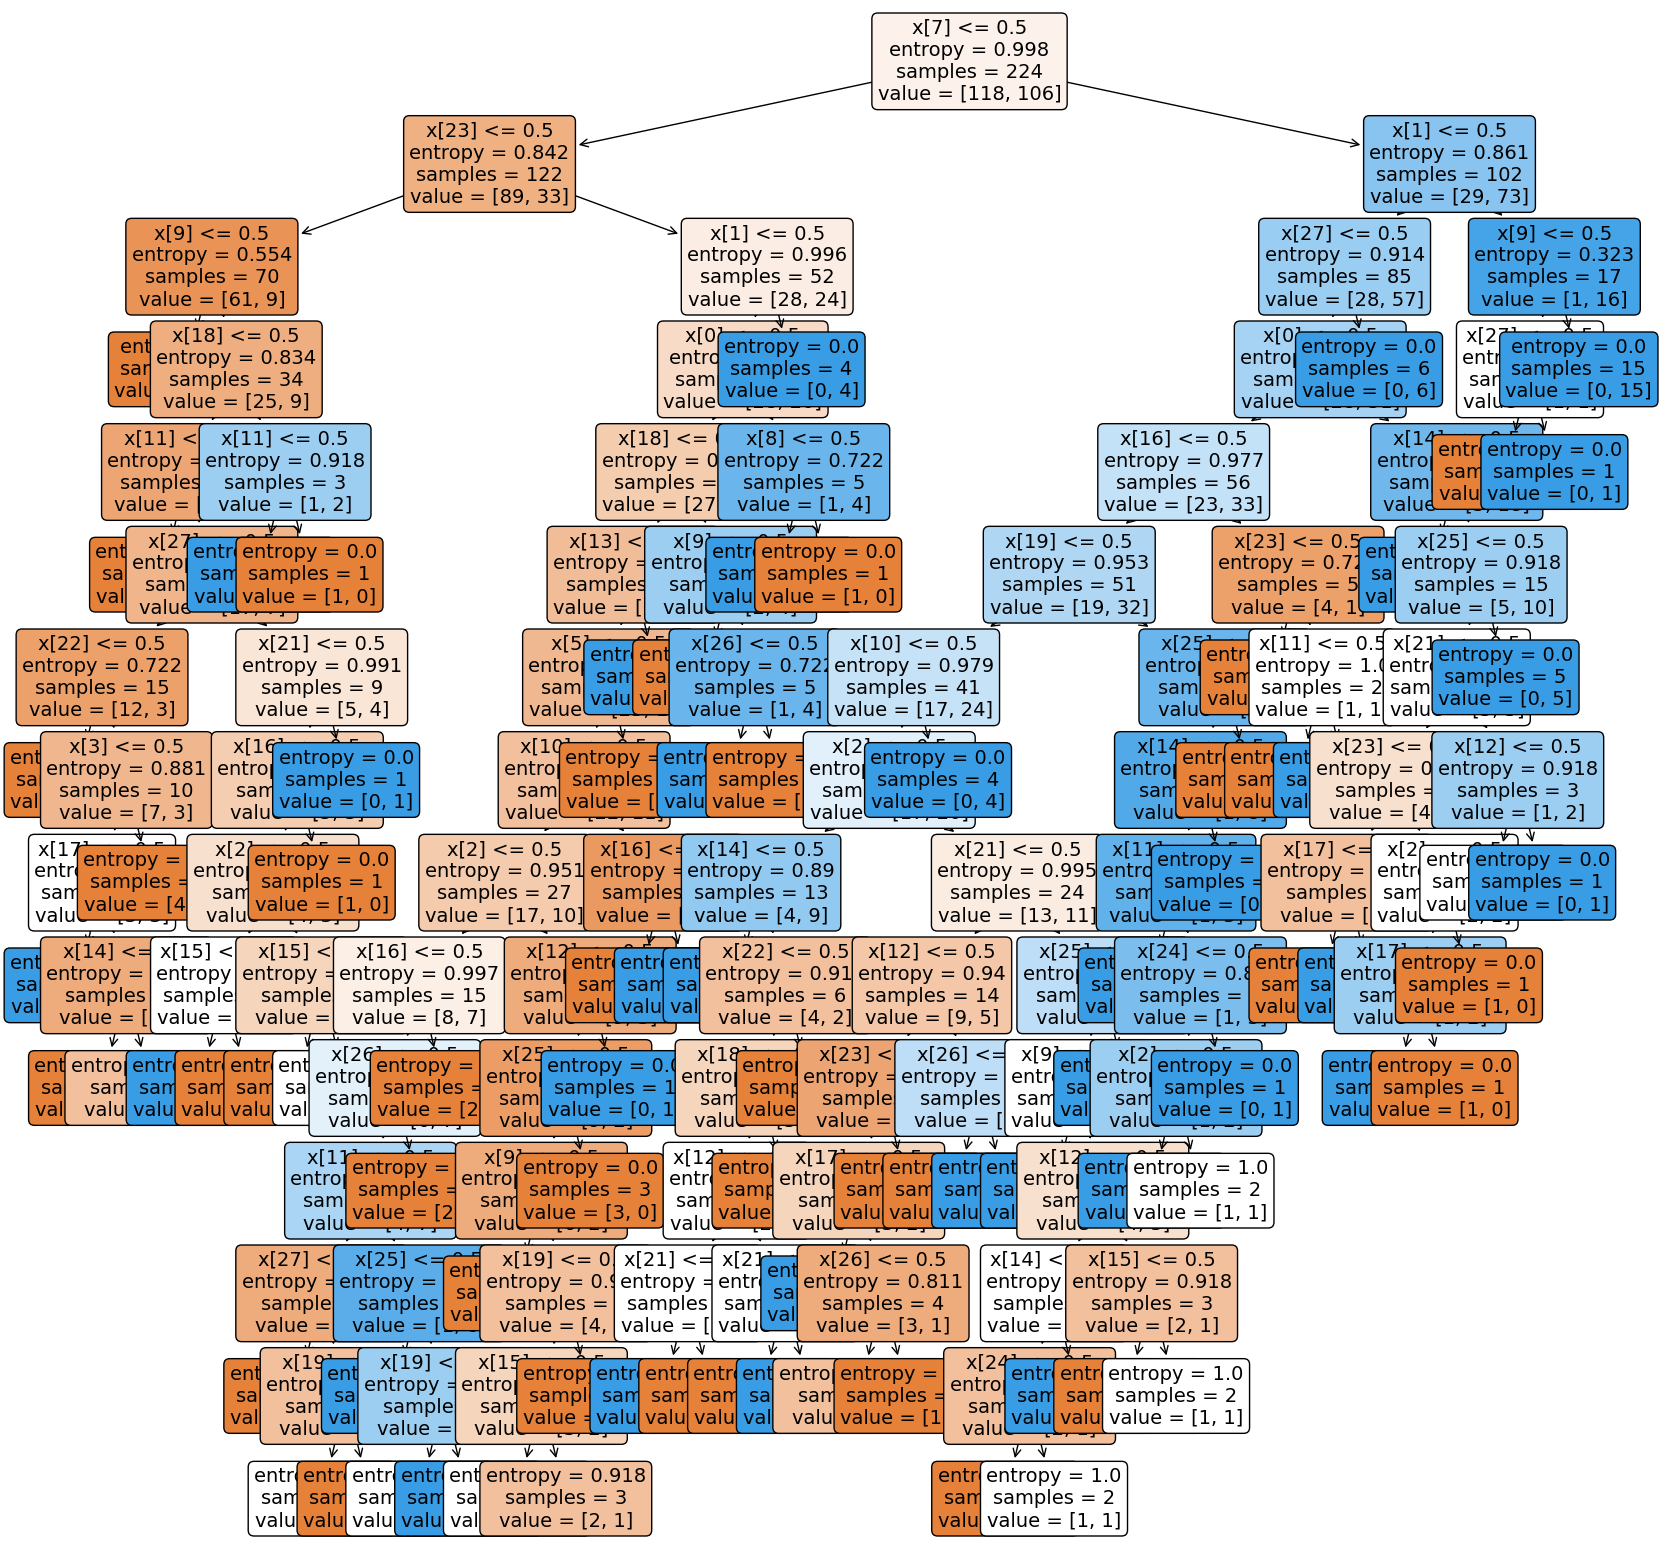

In [57]:
# Plota a árvore de decisão do TreeClassifier

clf.plot()

Além disso, percebe-se que a árvore de decisão também se simplificou, provavelmente pelo menor número de dados para treino.

### **Analisando o `y_est`**

Realizando o mesmo processo do classificador linear, é possível perceber que as escolhas também se tornaram mais equilibradas, com uma pequena tendência para classificar os casos como não AVC.

In [23]:
print(f'Número total de predições: {clf.y_est.shape[0]}')
print(f'Número de predições para AVC (positivo): {np.sum(clf.y_est > 0)}')
print(f'Número de predições para não AVC (negativo): {np.sum(clf.y_est < 0)}')

Número total de predições: 225
Número de predições para AVC (positivo): 107
Número de predições para não AVC (negativo): 118


### **Analisando (novamente) a Hipótese Nula**

Agora com poda nos dados.

In [24]:
# Descobre se temos mais 1s ou -1s no y_test

print(f'Number of 1s in y_test: {np.sum(clf.y_test == 1)}')
print(f'Number of -1s in y_test: {np.sum(clf.y_test == -1)}')

# Cria um Numpy array do tamanho do y_test com apenas 1s

y_test = np.ones(clf.y_test.shape) * 1

# Compara a acurácia do classificador com um que chuta 1 para tudo

print(f'\nTreeClassifier accuracy vs. 1s classifier accuracy: {clf.accuracy() * 100 :.2f}% vs. {np.mean(np.sign(clf.y_test)==np.sign(y_test)) * 100 :.2f}%')

Number of 1s in y_test: 109
Number of -1s in y_test: 116

TreeClassifier accuracy vs. 1s classifier accuracy: 63.56% vs. 48.44%


Mais uma vez, agora encontramos que o classificador performa melhor do que o classificador que chuta sempre a resposta mais frequente. Portanto, é possível rejeitar a hipótese nula e considerar o classificador desenvolvido como adequado para o problema.

Após esse processo, podemos trabalhar em encontrar fatores de risco para AVC, utilizando os classificadores desenvolvidos.

-------

# **Calculando as Features de Maior Importância**

Para cada classificador, rodamos 100 vezes e armazenamos as top 5 features que o classificador julgou como as que mais causam AVC's.

Nessa tarefa, usaremos o DataFrame com poda, para analisar uma situação mais equilibrada e mais realista, que contém o mínimo de *bias* possível.

### Classificador Linear

In [60]:
# Carrega o DataFrame

df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

# Poda o DataFrame para ter o mesmo número de stroke = 1 e stroke = 0

df = df[df['stroke'] == 1].append(df[df['stroke'] == 0].sample(n=df[df['stroke'] == 1].shape[0]))

C:\Users\neodr\AppData\Local\Temp\ipykernel_4852\1887799411.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df[df['stroke'] == 1].append(df[df['stroke'] == 0].sample(n=df[df['stroke'] == 1].shape[0]))


O processo de "rankeamento" foi realizado por pontuações. Cada vez que uma feature aparecia entre as top 5, ela ganhava 5 pontos caso fosse a com maior importância, 4 caso fosse a segunda maior importância, até 1 ponto para o quinto colocado. Ao final das 100 iterações, as 5 features com mais pontos foram consideradas as mais importantes.

In [86]:
# Roda o classificador linear cem vezes e salva em um dataframe as 5 features mais importantes

df_top_linear = pd.DataFrame(columns=['Feature', 'Points'])
for i in range(100):
    clf = LinearClassifier(df)
    clf.fit()
    clf.score()
    
    # Checa se as features mais importantes já estão no dataframe e adiciona seus pontos
    indices = np.argsort(clf.w.T)[-5:]
    for j in range(1, 6):
        feature = clf.X.columns[indices[0][-j]]
        if feature in df_top_linear['Feature'].values:
            df_top_linear.loc[feature, 'Points'] += j
        else:
            df_top_linear.loc[feature, 'Feature'] = feature
            df_top_linear.loc[feature, 'Points'] = j

In [87]:
# Ordena o dataframe por pontos e printa as 10 features mais importantes
df_top_linear = df_top_linear.groupby('Feature').sum().sort_values(by='Points', ascending=False)

df_top_linear.head(10)

Points
Feature                        
age_elder                   146
avg_glucose_level_high       88
work_type_children           71
work_type_Never_worked       70
bmi_overweight               68
Residence_type_Urban         65
ever_married_Yes             63
work_type_Self-employed      62
smoking_status_smokes        62
work_type_Private            60

Novamente, é possível perceber que a idade avançada se tornou um fator de importância. No entanto, o classificador linear ainda apresenta instabilidades, com features aparentemente não tão relevantes no topo, como `work_type_Never_worked` e `work_type_children`.

### Classificador por Árvore de Decisão

In [94]:
# Roda o classificador por árvore cem vezes e salva em um dataframe as 5 features mais importantes

df_top_tree = pd.DataFrame(columns=['Feature', 'Points'])
for i in range(100):
    clf = TreeClassifier(df)
    clf.fit()
    clf.score()

    # Checa se as features mais importantes já estão no dataframe e adiciona seus pontos
    indices = np.argsort(clf.tree.feature_importances_)[-5:]
    for j in range(1, 6):
        feature = clf.X.columns[indices[j - 1]]
        if feature in df_top_tree['Feature'].values:
            df_top_tree.loc[feature, 'Points'] += j
        else:
            df_top_tree.loc[feature, 'Feature'] = feature
            df_top_tree.loc[feature, 'Points'] = j

In [95]:
# Ordena o dataframe por pontos e printa as 10 features mais importantes
df_top_tree = df_top_tree.groupby('Feature').sum().sort_values(by='Points', ascending=False)

df_top_tree.head(10)

Points
Feature                            
age_elder                       495
age_adult                       184
bmi_obese                        99
hypertension                     88
bmi_normal                       78
ever_married_Yes                 52
avg_glucose_level_normal         51
work_type_Private                43
smoking_status_never smoked      40
bmi_overweight                   36

Assim como no classificador linear, a idade avançada se mostrou um fator de risco para AVC (agora com ainda mais pontos). Além disso, o classificador por árvore de decisão se mostrou mais estável, sem muitos fatores opostos no topo. Além disso, percebe-se features interessantes como `bmi_obese` e `hypertension`, que indicam possíveis riscos para AVC.

### Juntando os scores

Finalmente, juntamos os scores dos dois classificadores para encontrar, no geral, as features consideradas por eles de maior importância.

In [96]:
# Junta os dois dataframes e ordena por pontos

df_final = df_top_linear.append(df_top_tree).groupby('Feature').sum().sort_values(by='Points', ascending=False) 

df_final.head(10)

C:\Users\neodr\AppData\Local\Temp\ipykernel_4852\1493593643.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_top_linear.append(df_top_tree).groupby('Feature').sum().sort_values(by='Points', ascending=False)


Points
Feature                         
age_elder                    641
age_adult                    230
bmi_obese                    159
hypertension                 123
ever_married_Yes             115
bmi_overweight               104
work_type_Private            103
bmi_normal                   101
Residence_type_Urban         100
avg_glucose_level_normal      96

Além disso, buscamos questionar a prevalência dos dois principais fatores: idade e obesidade. 

No resultado obtido, a idade, de longe, se apresentou como possível fator de maior risco. No entanto, esse tipo de fator, junto a outros como `bmi_obese`, são features que podem ser consideradas como "causas" de fatores de risco, e não características em si. Por exemplo, um indivíduo idoso ou obeso tende a desenvolver doenças vasculares, como a **hipertensão**, essa sim causadora de acidentes vasculares cerebrais (como analisado também nos artigos no `README.md`). 

Uma hipótese possível é que, portanto, eles não são fatores do AVC em si, mas levam aos reais causadores do acidente. Assim, as amplas presenças de idade avançada e obesidade nos top 5 estariam ligadas a serem características "genéricas" ligadas a diversos causadores de AVC's.

Portanto, ao checar na bibliografia, dada essa hipótese, decidimos também focar nesses outros fatores de risco, como a hipertensão. 